# Driving Semantic Segmentation
with Eric Wolos

The objective of this project is to segment each pixel in each image into different classes. In this particular dataset, there are images taken while driving (features) and masks with labeled pixels (labels).

In order to generate a model, I will use a UNet model architecture which features an encoder/decoder series of convolution layers and skip connections.

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob
import cv2
import segmentation_models as sm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from pandas import read_csv
import numpy as np

Segmentation Models: using `keras` framework.


## Data Preprocessing

In [2]:
genPath = '/Users/ericwolos/ML/Computer vision/CamVid/'

In [3]:
classLabels = read_csv(f'{genPath}class_dict.csv')

In [4]:
# The RGB codes for each class
classLabels

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [5]:
classDict = {}
for row in classLabels.index:
    classDict[str(classLabels['r'][row])+str(classLabels['g'][row])+str(classLabels['b'][row])] = row

In [6]:
reverseClassDict = {}
for row in classLabels.index:
    reverseClassDict[row] = [classLabels['r'][row], classLabels['g'][row], classLabels['b'][row]]

In [7]:
numClasses = len(classLabels)

In [8]:
classDict

{'6412864': 0,
 '1920128': 1,
 '0128192': 2,
 '012864': 3,
 '12800': 4,
 '640128': 5,
 '640192': 6,
 '19212864': 7,
 '192192128': 8,
 '6464128': 9,
 '1280192': 10,
 '192064': 11,
 '12812864': 12,
 '1920192': 13,
 '1286464': 14,
 '64192128': 15,
 '64640': 16,
 '12864128': 17,
 '128128192': 18,
 '00192': 19,
 '192128128': 20,
 '128128128': 21,
 '64128192': 22,
 '0064': 23,
 '06464': 24,
 '19264128': 25,
 '1281280': 26,
 '192128192': 27,
 '64064': 28,
 '1921920': 29,
 '000': 30,
 '641920': 31}

In [9]:
sm.set_framework('tf.keras')

In [10]:
trainPath = f'{genPath}train'
trainMaskPath = f'{genPath}train_labels'

valPath = f'{genPath}val'
valMaskPath = f'{genPath}val_labels'

testPath = f'{genPath}test'
testMaskPath = f'{genPath}test_labels'

In [11]:
train = {
    'image':[],
    'mask':[]
}
val = {
    'image':[],
    'mask':[]
}
test = {
    'image':[],
    'mask':[]
}

In [12]:
def getData(dataDictionary , imageFolderPath, maskFolderPath, numClassses= 32, desiredShape = 256):
    
    dataDictionary['image'] = []
    dataDictionary['mask'] = []
    
    imagePathNames = glob.glob(f'{imageFolderPath}/*.png')
    maskPathNames = glob.glob(f'{maskFolderPath}/*.png')
    imagePathNames.sort()
    maskPathNames.sort()
    
    for index, i in enumerate(imagePathNames):
        im = plt.imread(i)
        mask = plt.imread(maskPathNames[index])*255
        
        im = cv2.resize(im, (desiredShape, desiredShape))
        mask = cv2.resize(mask, (desiredShape, desiredShape))
        
        newmask = np.ndarray((desiredShape, desiredShape, numClasses))
        for xIndex, x in enumerate(mask):
            for yIndex, y in enumerate(x):
                temp = np.ndarray(numClasses)
                temp.fill(0)
                code = str(int(y[0]))+str(int(y[1]))+str(int(y[2]))
                try:
                    temp[classDict[code]] = 1
                except:
                    # This is a really important point to note: when resizing images, the masks may be 
                    # introduced to pixels not in the classes.
                    # The result is the weird black borders caused in masks that are the result of the line below.
                    # Any pixel this function does not know what to do with will be made the class 'void'
                    temp[30] = 1
                newmask[xIndex][yIndex] = temp
        
        dataDictionary['image'].append(im)
        dataDictionary['mask'].append(newmask)
    
    return dataDictionary

In [13]:
train = getData(train, trainPath, trainMaskPath)
val = getData(val, valPath, valMaskPath)
test = getData(test, testPath, testMaskPath)

## Visualization

In [14]:
def translateMask(mask, desiredShape = 256):
    newmask = np.ndarray((desiredShape, desiredShape, 3))
    for xIndex, x in enumerate(mask):
        for yIndex, y in enumerate(x):
            temp = np.ndarray(3)
            code = np.argmax(y)
            # For each of the three channels
            for index in range(0,3):
                temp[index] = reverseClassDict[code][index]
            newmask[xIndex][yIndex] = temp
    return newmask/255

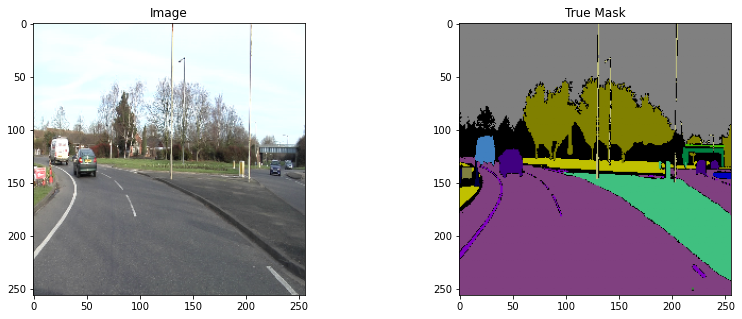

In [15]:
imageNumber = 25

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
plt.imshow(train['image'][imageNumber])
ax2 = plt.subplot(1,2,2)
plt.imshow(translateMask(train['mask'][imageNumber]))
ax1.set_title('Image')
ax2.set_title('True Mask')
plt.show()

## Moving Data to Tensors

Each image has a shape of 256 pixels x 256 pixels x 3 channels. Each mask however, has a shape of 256 pixels x 256 pixels x 32 classes, where the last vector of classes is one hot encoded.

In [16]:
trainX = tf.constant(train['image'])
trainY = tf.constant(train['mask'])
valX = tf.constant(val['image'])
valY = tf.constant(val['mask'])
testX = tf.constant(test['image'])
testY = tf.constant(test['mask'])

In [17]:
trainDataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
valDataset = tf.data.Dataset.from_tensor_slices((valX, valY))
testDataset = tf.data.Dataset.from_tensor_slices((testX, testY))

In [18]:
trainLen = len(train['image'])
batchSize = 8

In [19]:
trainDataset = trainDataset.cache().shuffle(trainLen).batch(batchSize)
valDataset = valDataset.cache().shuffle(trainLen).batch(batchSize)
testDataset = testDataset.cache().batch(batchSize)

## Model Architecture and Training

In [20]:
keras.backend.clear_session()
BACKBONE = 'efficientnetb0'
unet = sm.Unet(BACKBONE, encoder_weights='imagenet',classes=numClasses)

In [21]:
metric = tf.keras.metrics.IoU(32, range(0,32))

In [22]:
unet.compile(optimizer = 'Adam', loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), metrics = ['accuracy'] )

In [23]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                           

                                                                                                  
 block2b_expand_activation (Act  (None, None, None,   0          ['block2b_expand_bn[0][0]']      
 ivation)                       144)                                                              
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, None, None,   1296       ['block2b_expand_activation[0][0]
 D)                             144)                             ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, None, None,   576        ['block2b_dwconv[0][0]']         
 )                              144)                                                              
                                                                                                  
 block2b_a

 D)                             240)                             ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, None, None,   960        ['block3b_dwconv[0][0]']         
 )                              240)                                                              
                                                                                                  
 block3b_activation (Activation  (None, None, None,   0          ['block3b_bn[0][0]']             
 )                              240)                                                              
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block4b_activation (Activation  (None, None, None,   0          ['block4b_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_s

                                                                                                  
 block5a_activation (Activation  (None, None, None,   0          ['block5a_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, None, None,   0           ['block5c_activation[0][0]',     
                                672)                              'block5c_se_expand[0][0]']      
          

                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, None, None,   0           ['block6b_activation[0][0]',     
                                1152)                             'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, None, None,   221184      ['block6b_se_excite[0][0]']      
                                192)                                                              
                                                                                                  
 block6b_project_bn (BatchNorma  (None, None, None,   768        ['block6b_project_conv[0][0]']   
 lization)

 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, None, None,   0           ['block6d_activation[0][0]',     
                                1152)                             'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, None, None,   221184      ['block6d_se_excite[0][0]']      
                                192)                                                              
                                                                                                  
 block6d_p

                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0b_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_s

 on)                            32)                                                               
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, None, None,   0          ['decoder_stage3b_relu[0][0]']   
 ampling2D)                     32)                                                               
                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, None, None,   4608        ['decoder_stage4_upsampling[0][0]
                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
          

In [24]:
EarlyStop = EarlyStopping(patience=3,restore_best_weights=True)
ReduceLR = ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001, patience=1)
modelCheck = ModelCheckpoint('model1.hdf5',monitor='val_loss', verbose=1, save_best_only=True)
callback = [EarlyStop, modelCheck, ReduceLR]

In [25]:
history = unet.fit(trainDataset, 
         validation_data=valDataset, 
         epochs = 30, 
         callbacks=callback
        )

Epoch 1/30
47/47 [==============================] - ETA: 0s - loss: 2.3674 - accuracy: 0.5681
Epoch 1: val_loss improved from inf to 5.80280, saving model to model1.hdf5
47/47 [==============================] - 191s 4s/step - loss: 2.3674 - accuracy: 0.5681 - val_loss: 5.8028 - val_accuracy: 0.4879 - lr: 0.0010
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 1.7203 - accuracy: 0.7902
Epoch 2: val_loss improved from 5.80280 to 2.89320, saving model to model1.hdf5
47/47 [==============================] - 178s 4s/step - loss: 1.7203 - accuracy: 0.7902 - val_loss: 2.8932 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 1.6422 - accuracy: 0.8063
Epoch 3: val_loss improved from 2.89320 to 1.90966, saving model to model1.hdf5
47/47 [==============================] - 174s 4s/step - loss: 1.6422 - accuracy: 0.8063 - val_loss: 1.9097 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 4/30
47/47 [==============================] - E

47/47 [==============================] - ETA: 0s - loss: 1.4008 - accuracy: 0.8959
Epoch 25: val_loss improved from 1.46338 to 1.46326, saving model to model1.hdf5
47/47 [==============================] - 176s 4s/step - loss: 1.4008 - accuracy: 0.8959 - val_loss: 1.4633 - val_accuracy: 0.8706 - lr: 1.5625e-05
Epoch 26/30
47/47 [==============================] - ETA: 0s - loss: 1.3993 - accuracy: 0.8962
Epoch 26: val_loss did not improve from 1.46326

Epoch 26: ReduceLROnPlateau reducing learning rate to 1e-05.
47/47 [==============================] - 172s 4s/step - loss: 1.3993 - accuracy: 0.8962 - val_loss: 1.4633 - val_accuracy: 0.8706 - lr: 1.5625e-05
Epoch 27/30
47/47 [==============================] - ETA: 0s - loss: 1.4006 - accuracy: 0.8958
Epoch 27: val_loss did not improve from 1.46326
47/47 [==============================] - 171s 4s/step - loss: 1.4006 - accuracy: 0.8958 - val_loss: 1.4634 - val_accuracy: 0.8706 - lr: 1.0000e-05
Epoch 28/30
47/47 [============================

## Results and Testing

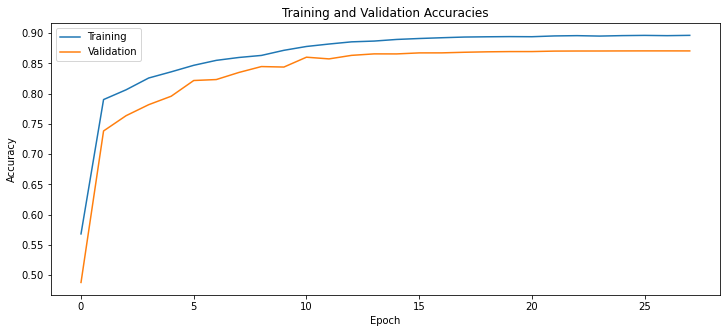

In [26]:
fig = plt.figure(figsize=(12,5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training","Validation"])
plt.title('Training and Validation Accuracies')
plt.show()

In [27]:
unetBest = tf.keras.models.load_model('model1.hdf5')

In [28]:
predictions = unetBest.predict(testDataset)

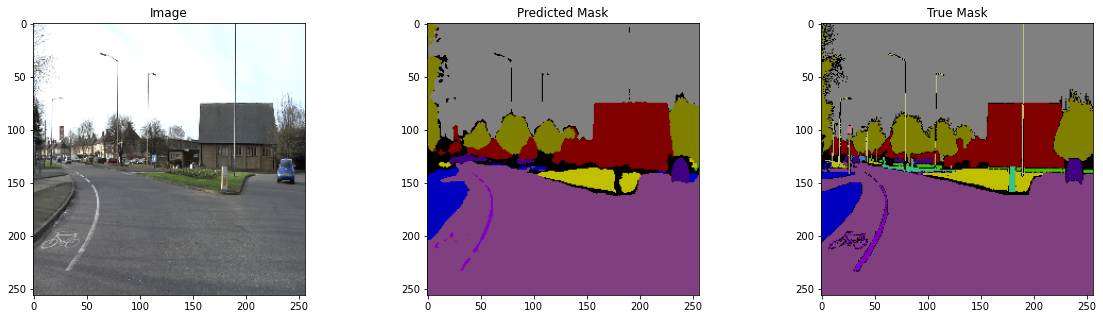

In [29]:
imageNumber = 96

plt.figure(figsize=(20,5))
ax1 = plt.subplot(1,3,1)
plt.imshow(test['image'][imageNumber])
ax2 = plt.subplot(1,3,2)
plt.imshow(translateMask(predictions[imageNumber]))
ax3 = plt.subplot(1,3,3)
plt.imshow(translateMask(test['mask'][imageNumber]))
ax1.set_title('Image')
ax2.set_title('Predicted Mask')
ax3.set_title('True Mask')
plt.show()

In [30]:
unetBest.evaluate(testDataset)

29/29 [==============================] - 27s 733ms/step - loss: 1.5189 - accuracy: 0.8513


[1.5188900232315063, 0.8513056039810181]